In [43]:
# ============================================================================
# CELL 1: SETUP & IMPORTS
# ============================================================================

# Install required packages
!pip install pandas numpy matplotlib seaborn plotly scikit-learn scipy gdown -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
import gdown
import os

In [44]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [45]:
# ============================================================================
# CELL 2: CREATE FOLDER STRUCTURE
# ============================================================================

import os

# Folders to create
folders = ['csv_files', 'outputs']

# Create subfolders in current directory
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"📂 Folder '{folder}' created!")
    else:
        print(f"📂 Folder '{folder}' already exists!")

print(f"\n✅ Folder structure ready!")
for folder in folders:
    print(f"   ├── {folder}/")


📂 Folder 'csv_files' already exists!
📂 Folder 'outputs' already exists!

✅ Folder structure ready!
   ├── csv_files/
   ├── outputs/


In [46]:
# ============================================================================
# CELL 3: DOWNLOAD DATA
# ============================================================================

import gdown
import pandas as pd
import os

# Set paths (directly in current folder)
csv_folder = "csv_files"

# Download trader data
print("\n📥 Downloading Trader Data...")
trader_file_id = '1yEIo7FFIrsu-QBNa10lc9iDEhrwi99bN'
trader_data_path = os.path.join(csv_folder, 'trader_data.csv')
gdown.download(f'https://drive.google.com/uc?id={trader_file_id}', trader_data_path, quiet=False)
df_trader = pd.read_csv(trader_data_path)

# Download sentiment data
print("\n📥 Downloading Sentiment Data...")
sentiment_file_id = '1cnykwuggsWQdR__XBDpAjvHbxpFvFSvh'
sentiment_data_path = os.path.join(csv_folder, 'sentiment_data.csv')
gdown.download(f'https://drive.google.com/uc?id={sentiment_file_id}', sentiment_data_path, quiet=False)
df_sentiment = pd.read_csv(sentiment_data_path)

print(f"\n✅ Trader Data loaded: {df_trader.shape[0]} rows, {df_trader.shape[1]} columns")
print(f"✅ Sentiment Data loaded: {df_sentiment.shape[0]} rows, {df_sentiment.shape[1]} columns")



📥 Downloading Trader Data...


Downloading...
From: https://drive.google.com/uc?id=1yEIo7FFIrsu-QBNa10lc9iDEhrwi99bN
To: /content/csv_files/trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 66.3MB/s]



📥 Downloading Sentiment Data...


Downloading...
From: https://drive.google.com/uc?id=1cnykwuggsWQdR__XBDpAjvHbxpFvFSvh
To: /content/csv_files/sentiment_data.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 80.8MB/s]


✅ Trader Data loaded: 211224 rows, 16 columns
✅ Sentiment Data loaded: 2644 rows, 4 columns


In [47]:
# ============================================================================
# CELL 4: DATA EXPLORATION
# ============================================================================

print("\n🔍 DATASET OVERVIEW")
print("="*80)

# Trader Data Overview
print("\n📊 Historical Trader Data:")
print(df_trader.head())
print("\nColumn Names:", df_trader.columns.tolist())
print("\nData Types:")
print(df_trader.dtypes)
print("\nMissing Values:")
print(df_trader.isnull().sum())
print("\nBasic Statistics:")
print(df_trader.describe())

# Sentiment Data Overview
print("\n📊 Fear & Greed Index Data:")
print(df_sentiment.head())
print("\nColumn Names:", df_sentiment.columns.tolist())
print("\nData Types:")
print(df_sentiment.dtypes)
print("\nMissing Values:")
print(df_sentiment.isnull().sum())


🔍 DATASET OVERVIEW

📊 Historical Trader Data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transacti

In [48]:
# ============================================================================
# CELL 5: DATA PREPROCESSING
# ============================================================================

print("\n🔧 DATA PREPROCESSING")
print("="*80)

# Ensure csv folder exists
if not os.path.exists(csv_folder):
    os.makedirs(csv_folder)
    print(f"📂 Folder '{csv_folder}' created!")

# Clean Trader Data
if 'Timestamp IST' in df_trader.columns:
    df_trader['datetime'] = pd.to_datetime(
        df_trader['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce'
    )
    df_trader['date'] = df_trader['datetime'].dt.date
    df_trader['hour'] = df_trader['datetime'].dt.hour
    df_trader['day_of_week'] = df_trader['datetime'].dt.dayofweek

# Strip column names
df_trader.columns = df_trader.columns.str.strip()
df_sentiment.columns = df_sentiment.columns.str.strip()

# Convert numeric columns
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    if col in df_trader.columns:
        df_trader[col] = pd.to_numeric(df_trader[col], errors='coerce')

# Clean Sentiment Data
if 'timestamp' in df_sentiment.columns:
    df_sentiment['timestamp'] = pd.to_numeric(df_sentiment['timestamp'], errors='coerce')
    df_sentiment['datetime'] = pd.to_datetime(
        df_sentiment['timestamp'], unit='s', errors='coerce'
    )
    df_sentiment['date'] = df_sentiment['datetime'].dt.date

if 'classification' in df_sentiment.columns:
    df_sentiment['classification'] = df_sentiment['classification'].str.strip()

# Remove duplicates
df_trader = df_trader.drop_duplicates()
df_sentiment = df_sentiment.drop_duplicates()

print(f"✅ Cleaned Trader Data: {df_trader.shape[0]} rows")
print(f"✅ Cleaned Sentiment Data: {df_sentiment.shape[0]} rows")

# Save cleaned data to csv_files folder
df_trader.to_csv(os.path.join(csv_folder, 'cleaned_trader_data.csv'), index=False)
df_sentiment.to_csv(os.path.join(csv_folder, 'cleaned_sentiment_data.csv'), index=False)
print(f"\n💾 Cleaned data saved to '{csv_folder}/'")



🔧 DATA PREPROCESSING
✅ Cleaned Trader Data: 211224 rows
✅ Cleaned Sentiment Data: 2644 rows

💾 Cleaned data saved to 'csv_files/'



📈 EXPLORATORY DATA ANALYSIS

1️⃣ Market Sentiment Distribution
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


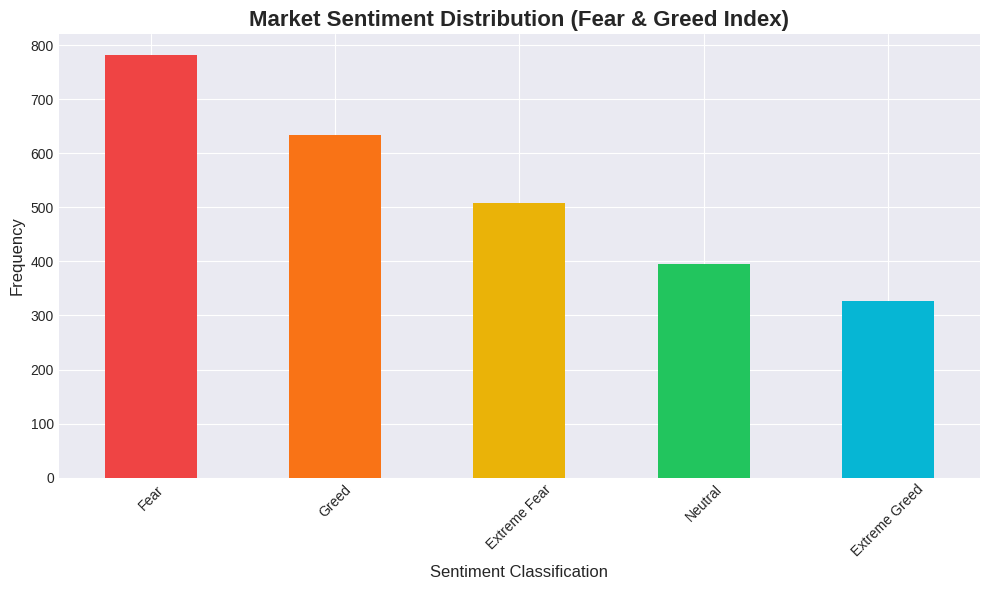

In [51]:
# ============================================================================
# CELL 6: EDA - SENTIMENT DISTRIBUTION
# ============================================================================

print("\n📈 EXPLORATORY DATA ANALYSIS")
print("="*80)

# Set outputs folder (same dir as notebook)
outputs_folder = "outputs"

# Ensure outputs folder exists
if not os.path.exists(outputs_folder):
    os.makedirs(outputs_folder)
    print(f"📂 Folder '{outputs_folder}' created!")

print("\n1️⃣ Market Sentiment Distribution")
sentiment_dist = df_sentiment['classification'].value_counts()
print(sentiment_dist)

plt.figure(figsize=(10, 6))
sentiment_dist.plot(
    kind='bar',
    color=['#ef4444', '#f97316', '#eab308', '#22c55e', '#06b6d4']
)
plt.title('Market Sentiment Distribution (Fear & Greed Index)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'sentiment_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()



2️⃣ Trading Volume Analysis

Buy vs Sell Distribution:
Side
SELL    108528
BUY     102696
Name: count, dtype: int64


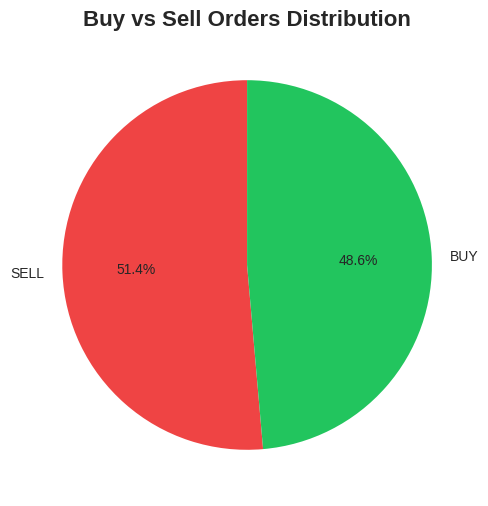

In [52]:
# ============================================================================
# CELL 7: EDA - TRADING VOLUME ANALYSIS
# ============================================================================

print("\n2️⃣ Trading Volume Analysis")
if 'Side' in df_trader.columns:
    side_dist = df_trader['Side'].value_counts()
    print("\nBuy vs Sell Distribution:")
    print(side_dist)

    plt.figure(figsize=(8, 6))
    colors = ['#22c55e' if x == 'BUY' else '#ef4444' for x in side_dist.index]
    plt.pie(side_dist.values, labels=side_dist.index, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Buy vs Sell Orders Distribution', fontsize=16, fontweight='bold')
    plt.savefig(os.path.join(outputs_folder, 'buy_sell_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()



3️⃣ Price Movement Analysis


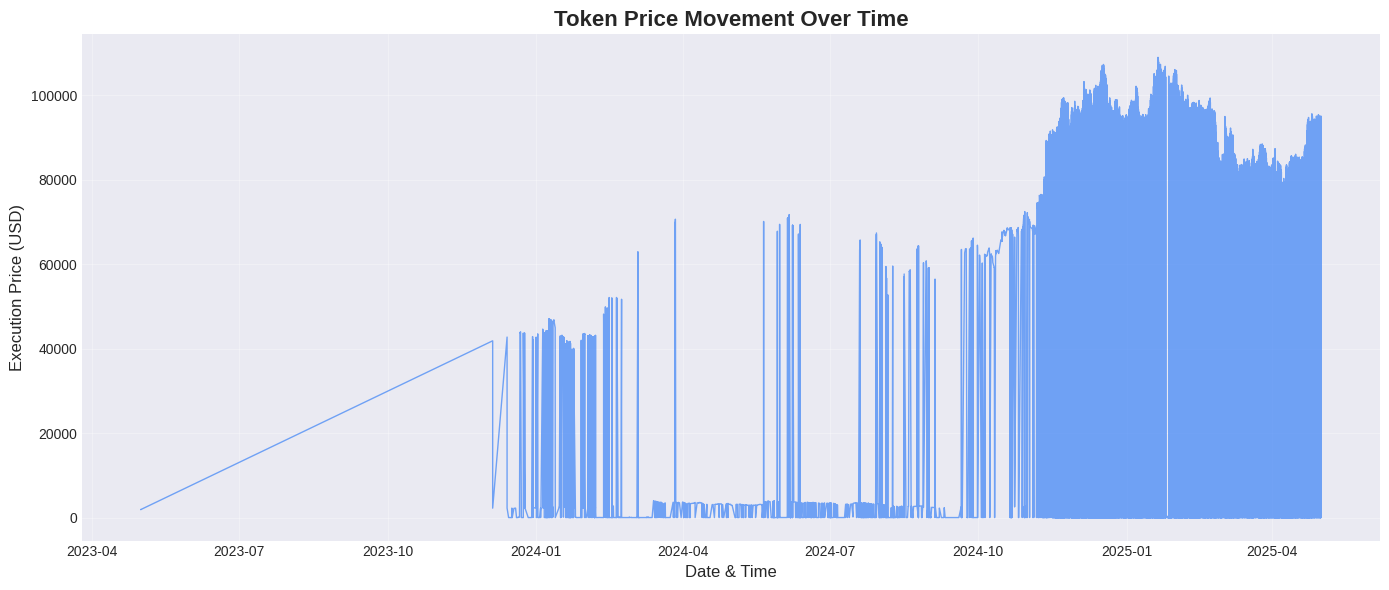

In [53]:
# ============================================================================
# CELL 8: EDA - PRICE MOVEMENT
# ============================================================================

print("\n3️⃣ Price Movement Analysis")
if 'Execution Price' in df_trader.columns and 'datetime' in df_trader.columns:
    plt.figure(figsize=(14, 6))
    df_trader_sorted = df_trader.sort_values('datetime')
    plt.plot(df_trader_sorted['datetime'], df_trader_sorted['Execution Price'],
             linewidth=1, alpha=0.7, color='#3b82f6')
    plt.title('Token Price Movement Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date & Time', fontsize=12)
    plt.ylabel('Execution Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_folder, 'price_movement.png'), dpi=300, bbox_inches='tight')
    plt.show()


4️⃣ Trading Volume Over Time


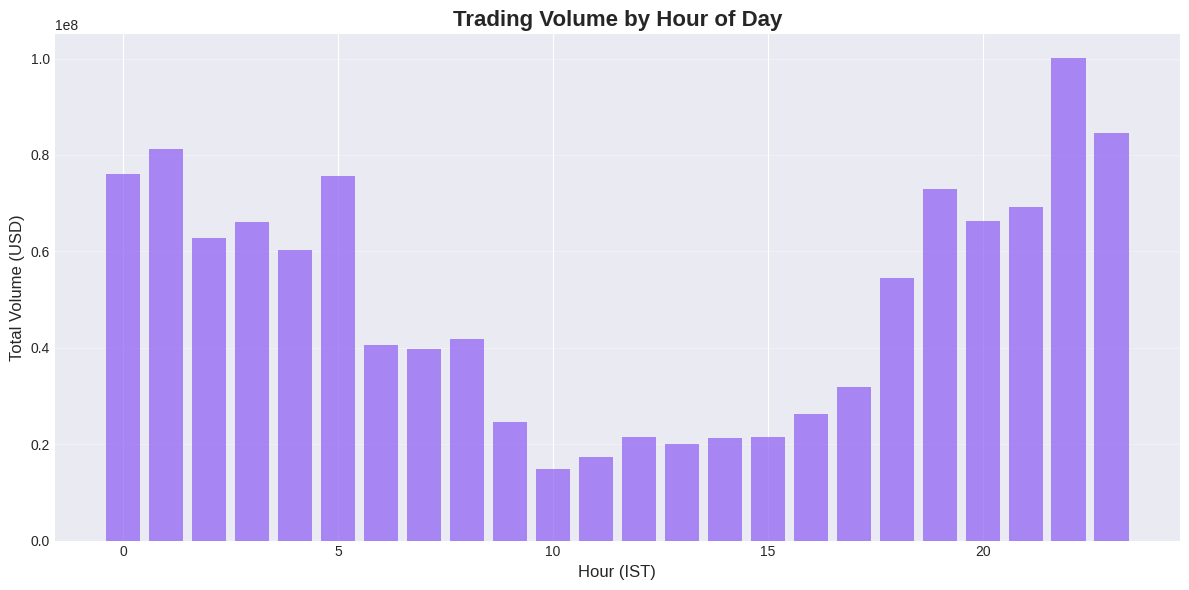

In [54]:
# ============================================================================
# CELL 9: EDA - VOLUME BY HOUR
# ============================================================================

print("\n4️⃣ Trading Volume Over Time")
if 'Size USD' in df_trader.columns and 'datetime' in df_trader.columns:
    volume_by_hour = df_trader.groupby('hour')['Size USD'].sum()

    plt.figure(figsize=(12, 6))
    plt.bar(volume_by_hour.index, volume_by_hour.values, color='#8b5cf6', alpha=0.7)
    plt.title('Trading Volume by Hour of Day', fontsize=16, fontweight='bold')
    plt.xlabel('Hour (IST)', fontsize=12)
    plt.ylabel('Total Volume (USD)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_folder, 'volume_by_hour.png'), dpi=300, bbox_inches='tight')
    plt.show()


5️⃣ Profit & Loss Analysis


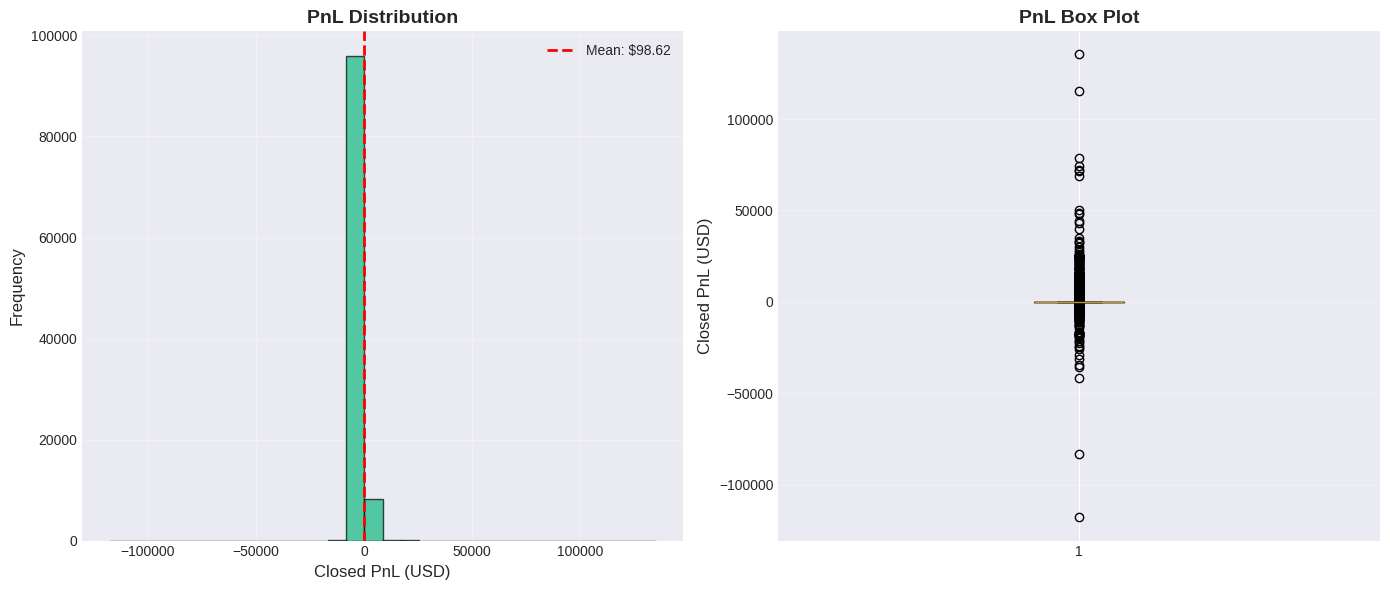


PnL Statistics:
Total Closed Trades: 104408
Total PnL: $10296958.94
Average PnL: $98.62
Median PnL: $6.06
Profitable Trades: 86869 (83.2%)
Losing Trades: 17539 (16.8%)


In [ ]:
# ============================================================================
# CELL 10: EDA - PNL ANALYSIS
# ============================================================================

print("\n5️⃣ Profit & Loss Analysis")
if 'Closed PnL' in df_trader.columns:
    pnl_data = df_trader[df_trader['Closed PnL'] != 0]['Closed PnL']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].hist(pnl_data, bins=30, color='#10b981', alpha=0.7, edgecolor='black')
    axes[0].axvline(pnl_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${pnl_data.mean():.2f}')
    axes[0].set_title('PnL Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Closed PnL (USD)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].boxplot(pnl_data, vert=True)
    axes[1].set_title('PnL Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Closed PnL (USD)', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(outputs_folder, 'pnl_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nPnL Statistics:")
    print(f"Total Closed Trades: {len(pnl_data)}")
    print(f"Total PnL: ${pnl_data.sum():.2f}")
    print(f"Average PnL: ${pnl_data.mean():.2f}")
    print(f"Median PnL: ${pnl_data.median():.2f}")
    print(f"Profitable Trades: {(pnl_data > 0).sum()} ({(pnl_data > 0).sum()/len(pnl_data)*100:.1f}%)")
    print(f"Losing Trades: {(pnl_data < 0).sum()} ({(pnl_data < 0).sum()/len(pnl_data)*100:.1f}%)")


In [55]:
# ============================================================================
# CELL 11: MERGE DATASETS
# ============================================================================

print("\n🔗 MERGING DATASETS")
print("="*80)

df_merged = df_trader.merge(df_sentiment[['date', 'classification', 'value']],
                             on='date', how='left')

print(f"✅ Merged dataset: {df_merged.shape[0]} rows")
print(f"Missing sentiment values: {df_merged['classification'].isnull().sum()}")

df_merged['classification'].fillna(method='ffill', inplace=True)

df_merged.to_csv(os.path.join(csv_folder, 'merged_analysis_data.csv'), index=False)
print(f"💾 Merged data saved to {csv_folder}/")



🔗 MERGING DATASETS
✅ Merged dataset: 211224 rows
Missing sentiment values: 6
💾 Merged data saved to csv_files/



🎯 TRADER BEHAVIOR VS MARKET SENTIMENT

1️⃣ Profitability by Market Sentiment
                Closed PnL                     Size USD
                       sum    mean  count           sum
classification                                         
Extreme Fear     739110.25   71.03  10406  5.689554e+07
Extreme Greed   2715171.31  130.21  20853  5.796224e+07
Fear            3357155.44  112.63  29808  2.396903e+08
Greed           2192601.27   87.07  25182  1.370127e+08
Neutral         1292920.68   71.20  18159  1.008995e+08


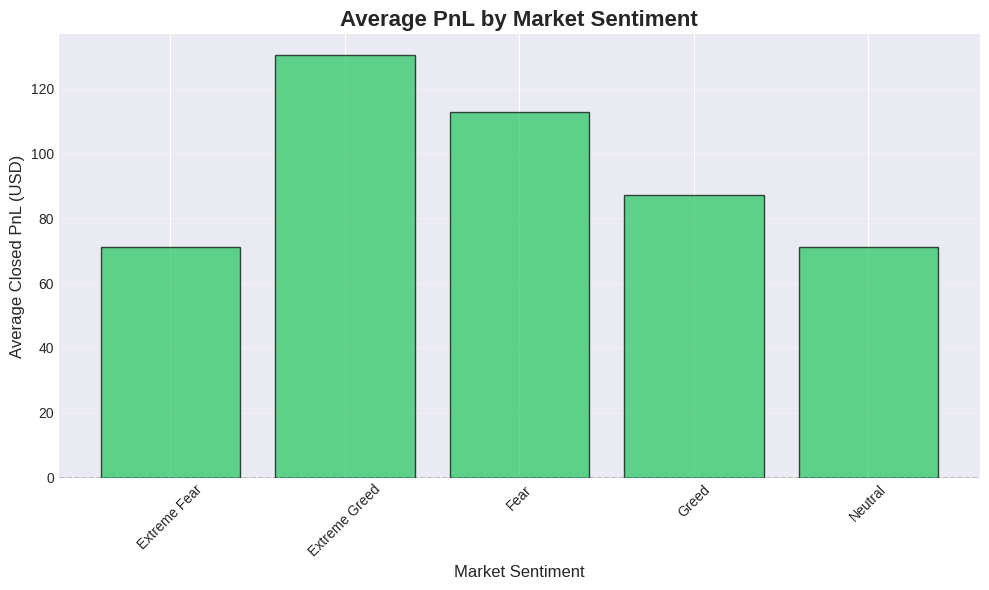

In [57]:
# ============================================================================
# CELL 12: PNL BY SENTIMENT
# ============================================================================

print("\n🎯 TRADER BEHAVIOR VS MARKET SENTIMENT")
print("="*80)

print("\n1️⃣ Profitability by Market Sentiment")
pnl_by_sentiment = df_merged[df_merged['Closed PnL'] != 0].groupby('classification').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum'
}).round(2)
print(pnl_by_sentiment)

pnl_summary = df_merged[df_merged['Closed PnL'] != 0].groupby('classification')['Closed PnL'].mean()

plt.figure(figsize=(10, 6))
colors = ['#ef4444' if x < 0 else '#22c55e' for x in pnl_summary.values]
plt.bar(pnl_summary.index, pnl_summary.values, color=colors, alpha=0.7, edgecolor='black')
plt.title('Average PnL by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average Closed PnL (USD)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'pnl_by_sentiment.png'), dpi=300, bbox_inches='tight')
plt.show()


2️⃣ Trading Volume by Market Sentiment
                         sum         mean  count
classification                                  
Extreme Fear    1.144843e+08  5349.731843  21400
Extreme Greed   1.244652e+08  3112.251565  39992
Fear            4.833248e+08  7816.109931  61837
Greed           2.886712e+08  5737.962662  50309
Neutral         1.802421e+08  4782.732661  37686


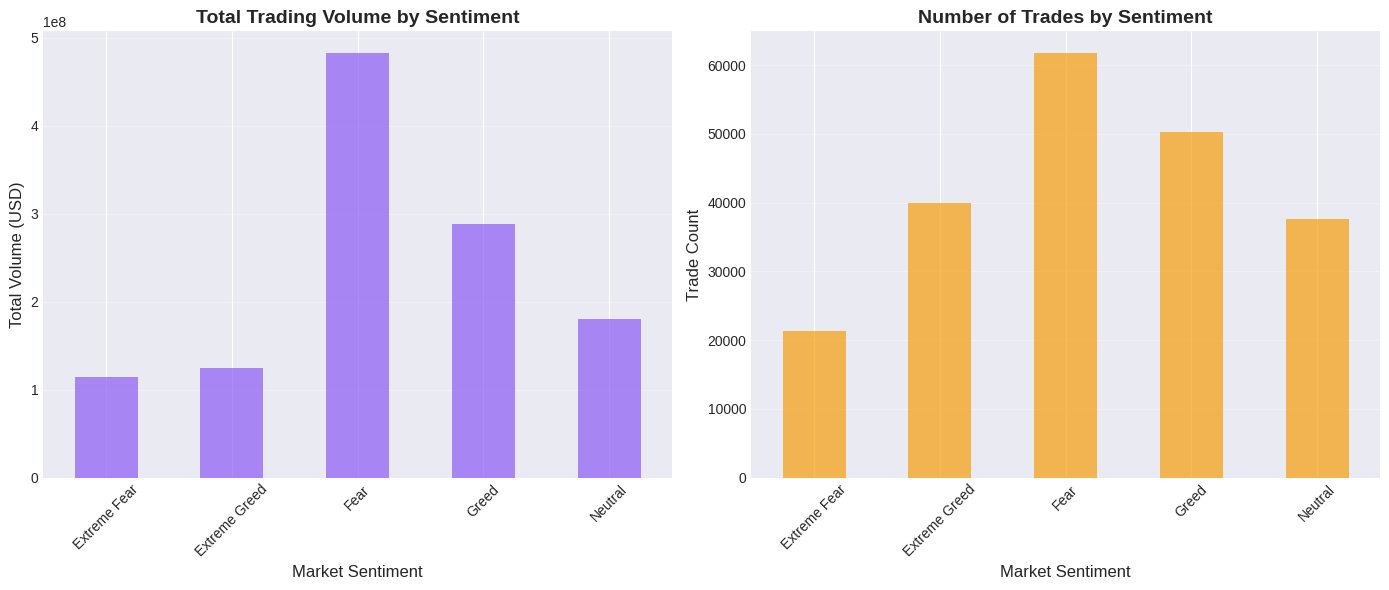

In [58]:
# ============================================================================
# CELL 13: VOLUME BY SENTIMENT
# ============================================================================

print("\n2️⃣ Trading Volume by Market Sentiment")
volume_by_sentiment = df_merged.groupby('classification')['Size USD'].agg(['sum', 'mean', 'count'])
print(volume_by_sentiment)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

volume_by_sentiment['sum'].plot(kind='bar', ax=axes[0], color='#8b5cf6', alpha=0.7)
axes[0].set_title('Total Trading Volume by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Market Sentiment', fontsize=12)
axes[0].set_ylabel('Total Volume (USD)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

volume_by_sentiment['count'].plot(kind='bar', ax=axes[1], color='#f59e0b', alpha=0.7)
axes[1].set_title('Number of Trades by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Market Sentiment', fontsize=12)
axes[1].set_ylabel('Trade Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'volume_by_sentiment.png'), dpi=300, bbox_inches='tight')
plt.show()


3️⃣ Buy/Sell Behavior by Market Sentiment
Side              BUY   SELL
classification              
Extreme Fear    51.10  48.90
Extreme Greed   44.86  55.14
Fear            48.95  51.05
Greed           48.86  51.14
Neutral         50.33  49.67


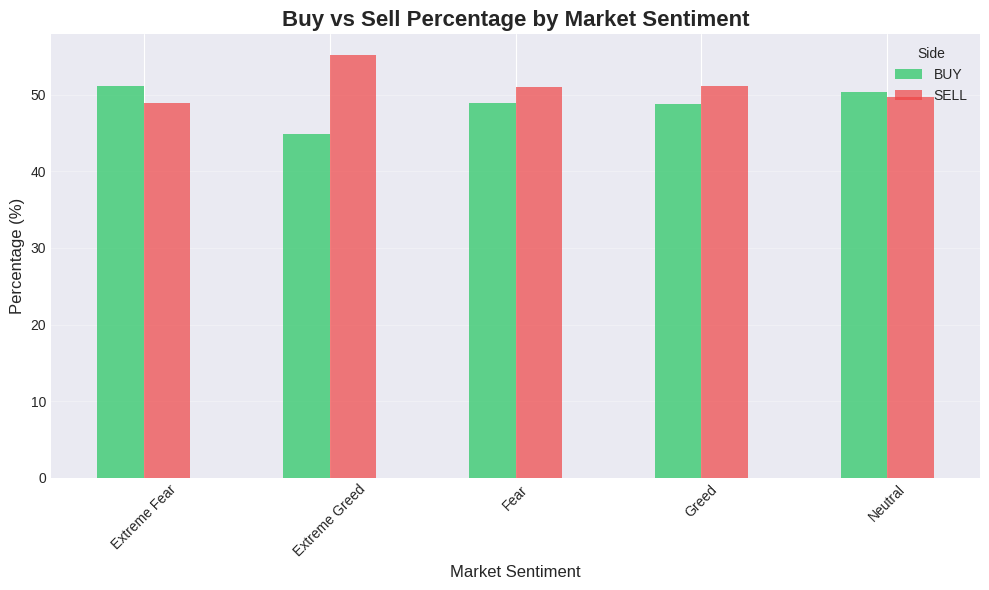

In [ ]:
# ============================================================================
# CELL 14: BUY/SELL BEHAVIOR BY SENTIMENT
# ============================================================================

print("\n3️⃣ Buy/Sell Behavior by Market Sentiment")
if 'Side' in df_merged.columns:
    behavior_sentiment = pd.crosstab(df_merged['classification'], df_merged['Side'], normalize='index') * 100
    print(behavior_sentiment.round(2))

    behavior_sentiment.plot(kind='bar', stacked=False, figsize=(10, 6),
                           color=['#22c55e', '#ef4444'], alpha=0.7)
    plt.title('Buy vs Sell Percentage by Market Sentiment', fontsize=16, fontweight='bold')
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.legend(title='Side', loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_folder, 'buy_sell_by_sentiment.png'), dpi=300, bbox_inches='tight')
    plt.show()


4️⃣ Win Rate by Market Sentiment
                  sum  count  win_rate
classification                        
Extreme Fear     7931  10406     76.22
Extreme Greed   18594  20853     89.17
Fear            26019  29808     87.29
Greed           19364  25182     76.90
Neutral         14961  18159     82.39


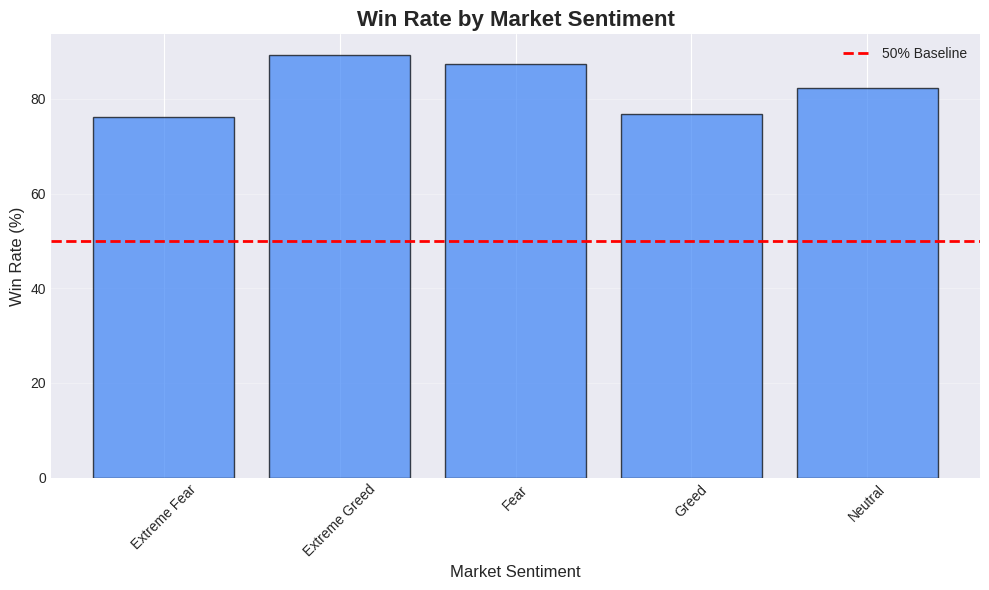

In [59]:
# ============================================================================
# CELL 15: WIN RATE BY SENTIMENT
# ============================================================================

print("\n4️⃣ Win Rate by Market Sentiment")
closed_trades = df_merged[df_merged['Closed PnL'] != 0].copy()
closed_trades['is_profitable'] = closed_trades['Closed PnL'] > 0

win_rate_by_sentiment = closed_trades.groupby('classification')['is_profitable'].agg(['sum', 'count'])
win_rate_by_sentiment['win_rate'] = (win_rate_by_sentiment['sum'] / win_rate_by_sentiment['count'] * 100).round(2)
print(win_rate_by_sentiment)

plt.figure(figsize=(10, 6))
plt.bar(win_rate_by_sentiment.index, win_rate_by_sentiment['win_rate'],
        color='#3b82f6', alpha=0.7, edgecolor='black')
plt.title('Win Rate by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)
plt.axhline(50, color='red', linestyle='--', linewidth=2, label='50% Baseline')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'win_rate_by_sentiment.png'), dpi=300, bbox_inches='tight')
plt.show()


💡 ADVANCED INSIGHTS & PATTERNS

1️⃣ Correlation between Fear & Greed Value and Trading Performance
               value  Closed PnL  Size USD
value       1.000000    0.009237 -0.033116
Closed PnL  0.009237    1.000000  0.162588
Size USD   -0.033116    0.162588  1.000000


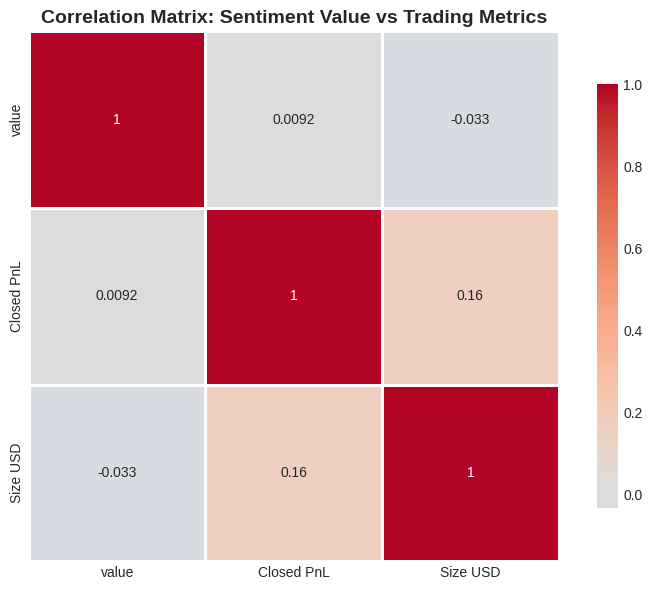

In [60]:

# ============================================================================
# CELL 16: CORRELATION ANALYSIS
# ============================================================================

print("\n💡 ADVANCED INSIGHTS & PATTERNS")
print("="*80)

print("\n1️⃣ Correlation between Fear & Greed Value and Trading Performance")
if 'value' in df_merged.columns:
    correlation_data = df_merged[df_merged['Closed PnL'] != 0][['value', 'Closed PnL', 'Size USD']].corr()
    print(correlation_data)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: Sentiment Value vs Trading Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_folder, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()


2️⃣ Intraday Trading Patterns


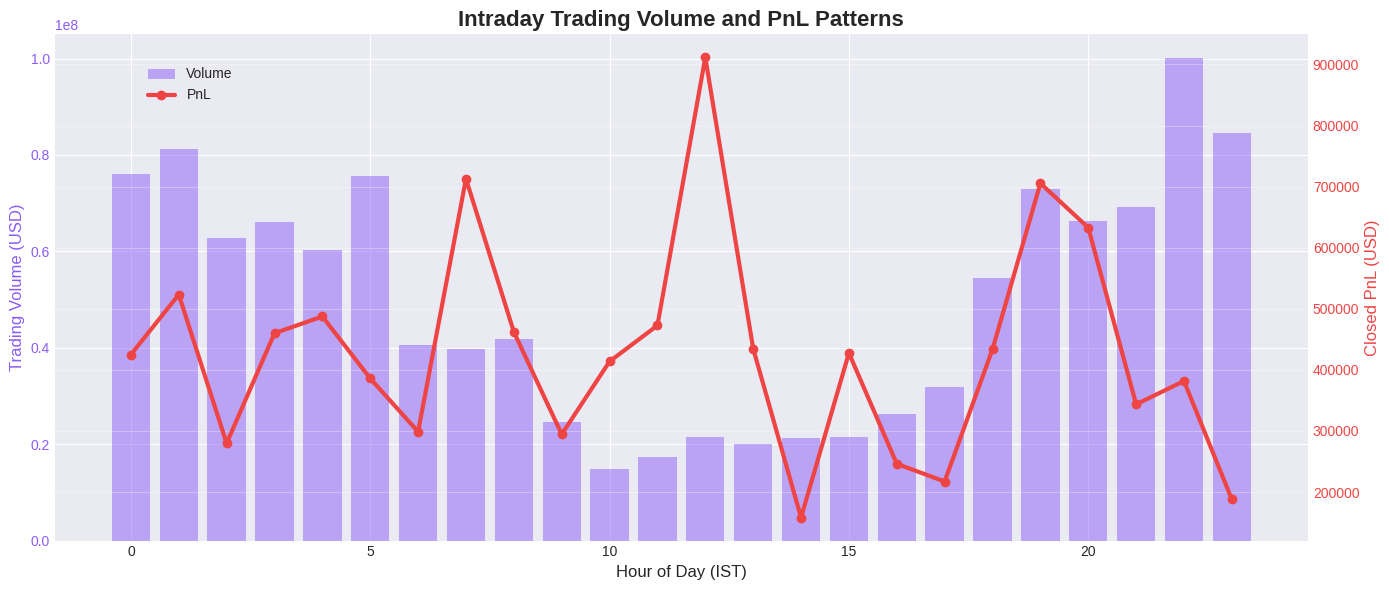

In [61]:
# ============================================================================
# CELL 17: INTRADAY PATTERNS
# ============================================================================

print("\n2️⃣ Intraday Trading Patterns")
hourly_metrics = df_merged.groupby('hour').agg({
    'Size USD': 'sum',
    'Closed PnL': 'sum'
}).round(2)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(hourly_metrics.index, hourly_metrics['Size USD'], color='#8b5cf6', alpha=0.5, label='Volume')
ax1.set_xlabel('Hour of Day (IST)', fontsize=12)
ax1.set_ylabel('Trading Volume (USD)', fontsize=12, color='#8b5cf6')
ax1.tick_params(axis='y', labelcolor='#8b5cf6')

ax2 = ax1.twinx()
ax2.plot(hourly_metrics.index, hourly_metrics['Closed PnL'], color='#ef4444',
         linewidth=3, marker='o', label='PnL')
ax2.set_ylabel('Closed PnL (USD)', fontsize=12, color='#ef4444')
ax2.tick_params(axis='y', labelcolor='#ef4444')

plt.title('Intraday Trading Volume and PnL Patterns', fontsize=16, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'intraday_patterns.png'), dpi=300, bbox_inches='tight')
plt.show()

In [62]:
# ============================================================================
# CELL 18: KEY FINDINGS SUMMARY
# ============================================================================

print("\n📋 KEY FINDINGS SUMMARY")
print("="*80)

total_trades = len(df_trader)
total_volume = df_trader['Size USD'].sum()
total_pnl = df_trader[df_trader['Closed PnL'] != 0]['Closed PnL'].sum()
win_rate = (df_trader[df_trader['Closed PnL'] > 0].shape[0] / df_trader[df_trader['Closed PnL'] != 0].shape[0] * 100)

print(f"""
🎯 OVERALL TRADING METRICS:
   • Total Trades: {total_trades:,}
   • Total Trading Volume: ${total_volume:,.2f}
   • Total Closed PnL: ${total_pnl:,.2f}
   • Overall Win Rate: {win_rate:.2f}%
   • Average Trade Size: ${df_trader['Size USD'].mean():,.2f}

📊 SENTIMENT-BASED INSIGHTS:
""")

for sentiment in df_merged['classification'].dropna().unique():
    sentiment_data = df_merged[df_merged['classification'] == sentiment]
    sentiment_pnl = sentiment_data[sentiment_data['Closed PnL'] != 0]['Closed PnL']

    if len(sentiment_pnl) > 0:
        sentiment_win_rate = (sentiment_pnl > 0).sum() / len(sentiment_pnl) * 100
        print(f"""
   {sentiment}:
      - Trades: {len(sentiment_data)}
      - Total PnL: ${sentiment_pnl.sum():.2f}
      - Avg PnL: ${sentiment_pnl.mean():.2f}
      - Win Rate: {sentiment_win_rate:.1f}%
        """)

print("\n✅ Basic Analysis Complete!")



📋 KEY FINDINGS SUMMARY

🎯 OVERALL TRADING METRICS:
   • Total Trades: 211,224
   • Total Trading Volume: $1,191,187,442.46
   • Total Closed PnL: $10,296,958.94
   • Overall Win Rate: 83.20%
   • Average Trade Size: $5,639.45

📊 SENTIMENT-BASED INSIGHTS:


   Extreme Greed:
      - Trades: 39992
      - Total PnL: $2715171.31
      - Avg PnL: $130.21
      - Win Rate: 89.2%
        

   Extreme Fear:
      - Trades: 21400
      - Total PnL: $739110.25
      - Avg PnL: $71.03
      - Win Rate: 76.2%
        

   Fear:
      - Trades: 61837
      - Total PnL: $3357155.44
      - Avg PnL: $112.63
      - Win Rate: 87.3%
        

   Greed:
      - Trades: 50309
      - Total PnL: $2192601.27
      - Avg PnL: $87.07
      - Win Rate: 76.9%
        

   Neutral:
      - Trades: 37686
      - Total PnL: $1292920.68
      - Avg PnL: $71.20
      - Win Rate: 82.4%
        

✅ Basic Analysis Complete!


In [63]:
# ============================================================================
# CELL 19: FEATURE ENGINEERING FOR ML
# ============================================================================

print("\n🔧 FEATURE ENGINEERING FOR MACHINE LEARNING")
print("="*80)

df_features = df_merged.copy()

# Price-based features
df_features['price_change'] = df_features.groupby('Account')['Execution Price'].pct_change()
df_features['volume_ma_3'] = df_features.groupby('Account')['Size USD'].rolling(window=3).mean().reset_index(0, drop=True)
df_features['price_ma_5'] = df_features.groupby('Account')['Execution Price'].rolling(window=5).mean().reset_index(0, drop=True)

# Position-based features
df_features['position_size_usd'] = df_features['Size USD']
df_features['position_change'] = df_features.groupby('Account')['Start Position'].diff()

# Sentiment features
le_sentiment = LabelEncoder()
df_features['sentiment_encoded'] = le_sentiment.fit_transform(df_features['classification'].fillna('Unknown'))
df_features['sentiment_value'] = df_features['value'].fillna(df_features['value'].median())

# Time-based features
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

# Target variable
df_features['is_profitable'] = (df_features['Closed PnL'] > 0).astype(int)

# Remove critical NaNs
df_features = df_features.dropna(subset=['Closed PnL', 'classification'])

# Additional derived features
df_features['price_vol_5'] = df_features.groupby('Account')['Execution Price'].rolling(5).std().reset_index(0, drop=True)
df_features['volume_ratio_ma3'] = df_features['Size USD'] / (df_features['volume_ma_3'] + 1e-6)
df_features['prev_trade_profitable'] = df_features.groupby('Account')['is_profitable'].shift(1).fillna(0)
df_features['large_trade'] = (df_features['Size USD'] > df_features['Size USD'].quantile(0.9)).astype(int)
df_features['price_change_x_volume'] = df_features['price_change'] * df_features['Size USD']
df_features['hour_cos_x_sentiment'] = df_features['hour_cos'] * df_features['sentiment_value']

print(f"✅ Feature engineering complete!")
print(f"Total features created: {df_features.shape[1]}")
print(f"Samples for modeling: {df_features.shape[0]}")



🔧 FEATURE ENGINEERING FOR MACHINE LEARNING
✅ Feature engineering complete!
Total features created: 39
Samples for modeling: 211224


In [64]:
# ============================================================================
# CELL 20: MACHINE LEARNING MODEL
# ============================================================================

print("\n🤖 MACHINE LEARNING MODEL: TRADE PROFITABILITY PREDICTION")
print("="*80)

closed_trades = df_features[df_features['Closed PnL'] != 0].copy()

# Feature Selection
feature_cols = [
    'Execution Price', 'Size USD', 'sentiment_encoded', 'sentiment_value',
    'hour_sin', 'hour_cos', 'is_weekend', 'Start Position'
]

X = closed_trades[feature_cols].fillna(0)
y = closed_trades['is_profitable']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Positive class ratio: {y_train.mean():.2%}")

# Random Forest Model
print("\n1️⃣ Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Predictions
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_rf = (y_proba_rf > threshold).astype(int)

# Evaluation
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=['Unprofitable', 'Profitable']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")



🤖 MACHINE LEARNING MODEL: TRADE PROFITABILITY PREDICTION

Training samples: 83526
Testing samples: 20882
Positive class ratio: 83.20%

1️⃣ Training Random Forest Classifier...

Random Forest Performance:
              precision    recall  f1-score   support

Unprofitable       0.89      0.78      0.83      3508
  Profitable       0.96      0.98      0.97     17374

    accuracy                           0.95     20882
   macro avg       0.92      0.88      0.90     20882
weighted avg       0.95      0.95      0.95     20882

ROC-AUC Score: 0.9747


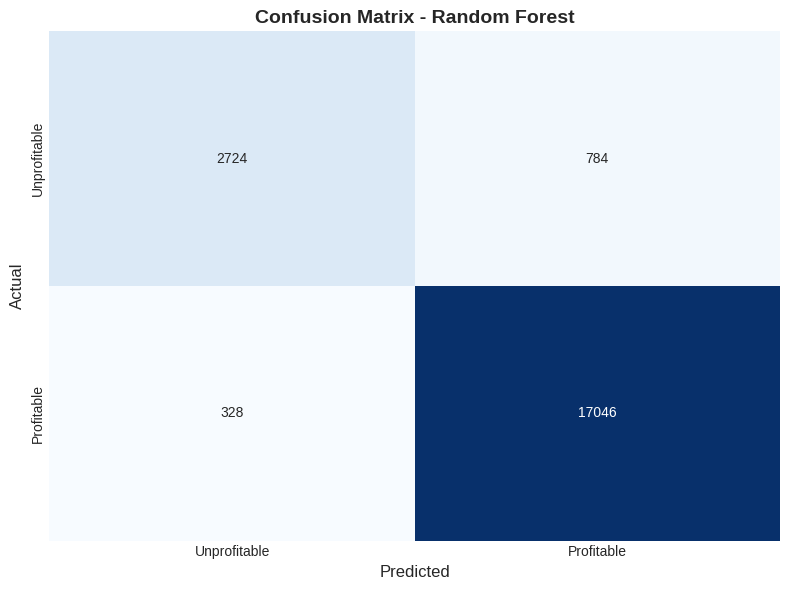

In [65]:
# ============================================================================
# CELL 21: CONFUSION MATRIX
# ============================================================================

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Unprofitable', 'Profitable'],
            yticklabels=['Unprofitable', 'Profitable'])
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'ml_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()


Feature Importance:
             feature  importance
0    Execution Price    0.287011
7     Start Position    0.225967
3    sentiment_value    0.189055
4           hour_sin    0.093568
5           hour_cos    0.090587
2  sentiment_encoded    0.050622
1           Size USD    0.042044
6         is_weekend    0.021146


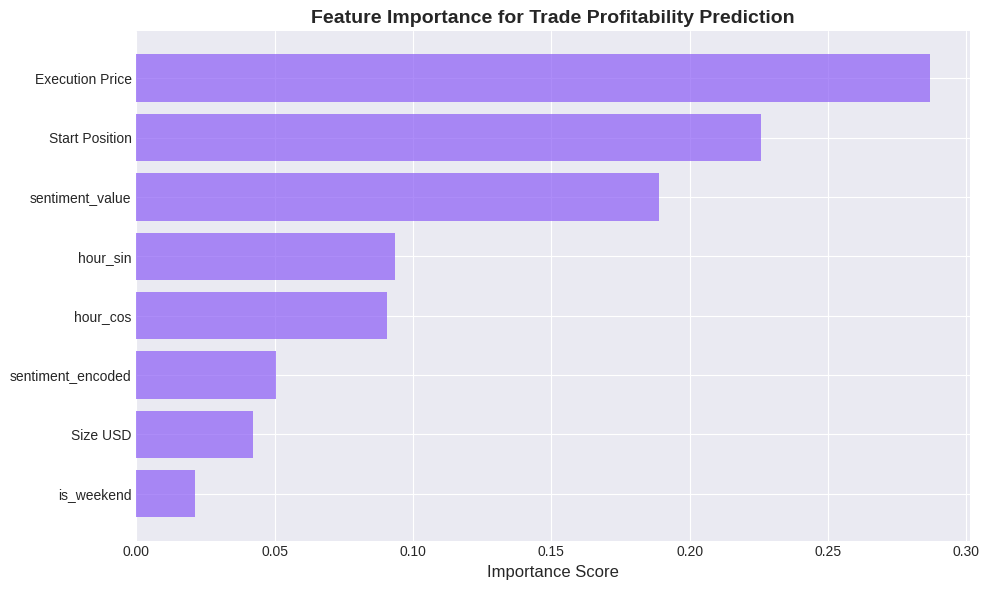

In [ ]:
# ============================================================================
# CELL 22: FEATURE IMPORTANCE
# ============================================================================

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#8b5cf6', alpha=0.7)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance for Trade Profitability Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'ml_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

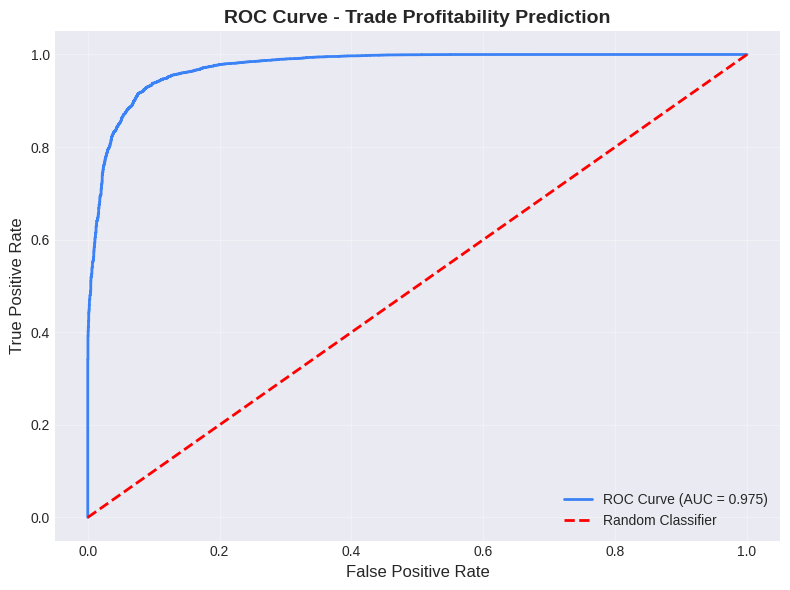


✅ Machine Learning Analysis Complete!


In [ ]:
# ============================================================================
# CELL 23: ROC CURVE
# ============================================================================

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3b82f6', linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Trade Profitability Prediction', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(outputs_folder, 'ml_roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Machine Learning Analysis Complete!")

In [66]:
# Folders
output_folder = "outputs"
csv_folder = "csv_files"

# Create folders if they don't exist
os.makedirs(outputs_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)


⚠️ RISK ANALYSIS

1️⃣ Value at Risk (VaR) Analysis by Sentiment
       Sentiment  VaR_95%  VaR_99%   Max_Loss   Max_Gain  Std_Dev
0  Extreme Greed    -5.84  -135.43  -10259.47   44223.45  1058.13
1   Extreme Fear  -198.70 -1211.74  -31036.69  115287.00  1628.41
2           Fear   -17.78  -236.60  -35681.75  135329.09  1344.78
3          Greed   -37.76  -417.53 -117990.10   74530.52  1581.96
4        Neutral   -27.33  -359.88  -24500.00   48504.10   743.21


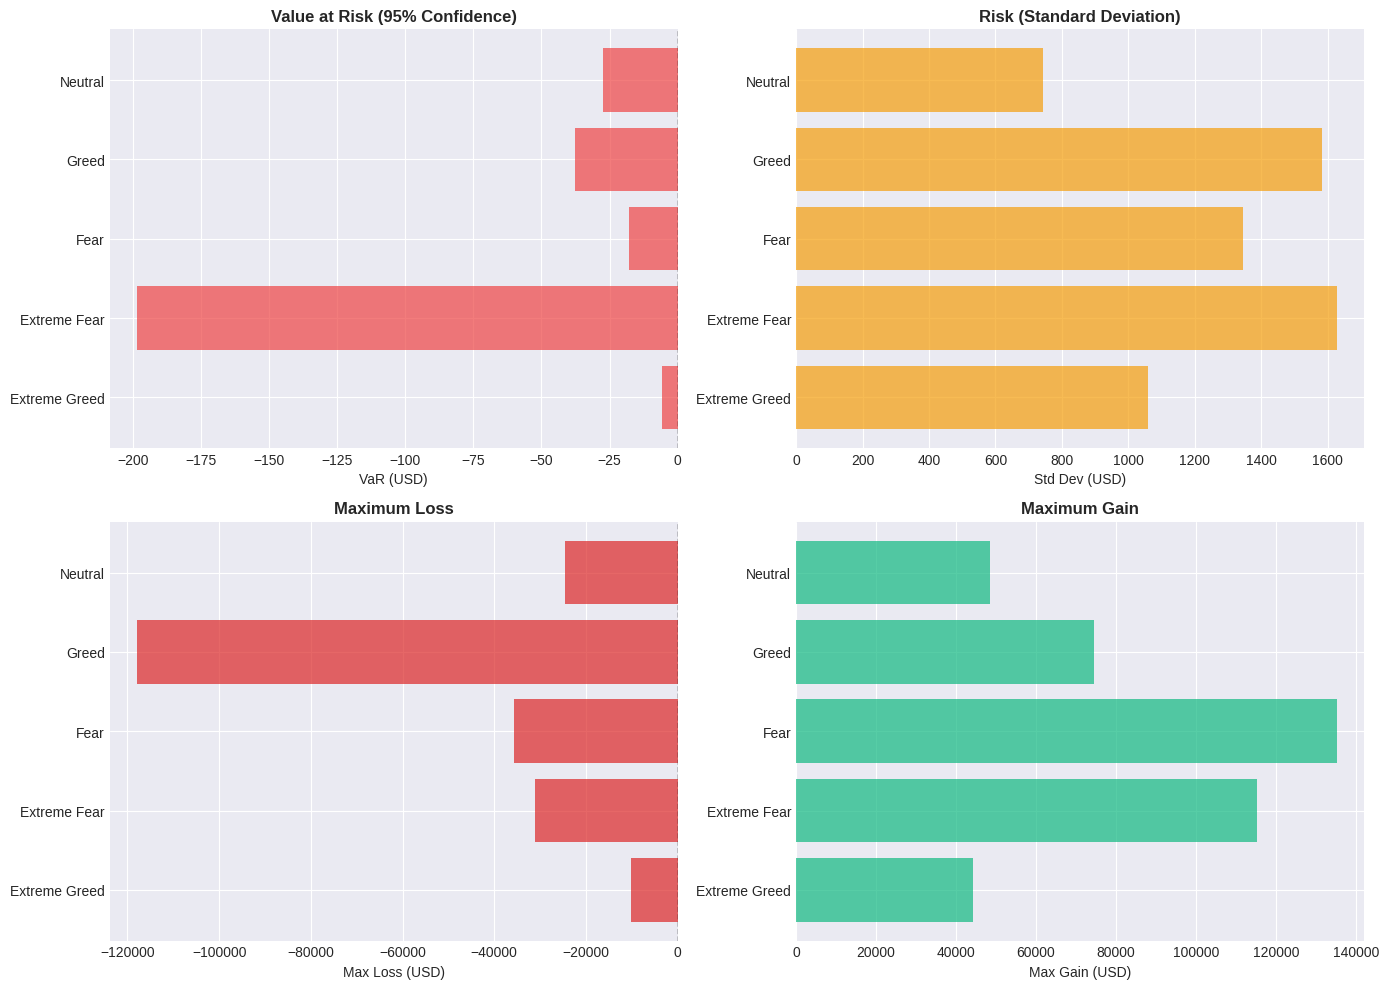


2️⃣ Risk-Adjusted Returns (Sharpe Ratio)
       Sentiment  Mean_Return    Std_Dev  Sharpe_Ratio
0  Extreme Greed     130.2053  1058.1261        0.1231
4        Neutral      71.2000   743.2129        0.0958
2           Fear     112.6260  1344.7784        0.0838
3          Greed      87.0702  1581.9644        0.0550
1   Extreme Fear      71.0273  1628.4083        0.0436


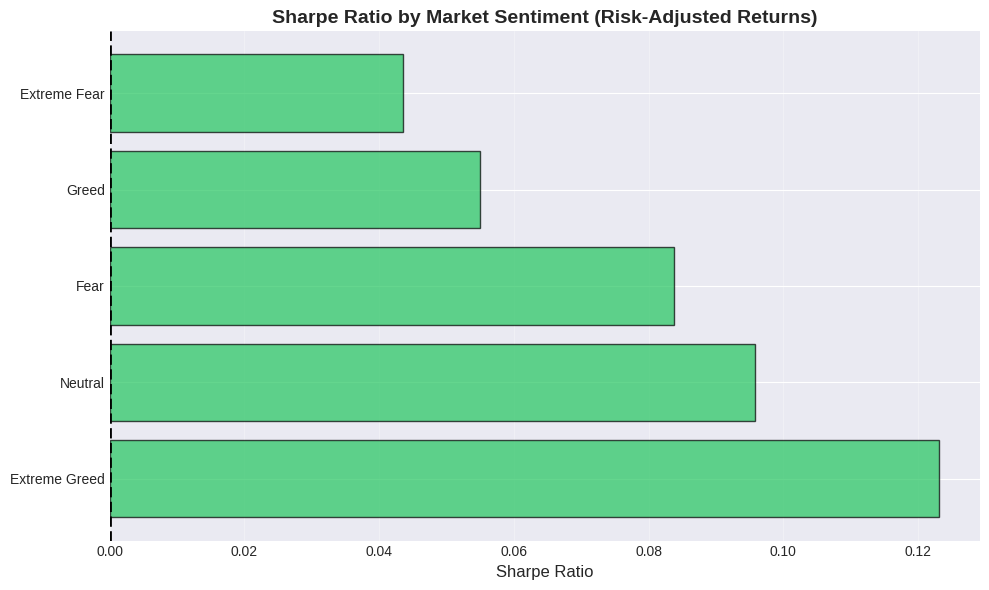

In [67]:
# ============================================================================
# 24. RISK ANALYSIS
# ============================================================================

print("\n⚠️ RISK ANALYSIS")
print("="*80)

# 24.1 Value at Risk (VaR) by Sentiment
print("\n1️⃣ Value at Risk (VaR) Analysis by Sentiment")

var_results = []
for sentiment in df_features['classification'].dropna().unique():
    sentiment_pnl = df_features[df_features['classification'] == sentiment]['Closed PnL']
    sentiment_pnl = sentiment_pnl[sentiment_pnl != 0]

    if len(sentiment_pnl) > 0:
        var_95 = np.percentile(sentiment_pnl, 5)
        var_99 = np.percentile(sentiment_pnl, 1)
        max_loss = sentiment_pnl.min()
        max_gain = sentiment_pnl.max()

        var_results.append({
            'Sentiment': sentiment,
            'VaR_95%': var_95,
            'VaR_99%': var_99,
            'Max_Loss': max_loss,
            'Max_Gain': max_gain,
            'Std_Dev': sentiment_pnl.std()
        })

var_df = pd.DataFrame(var_results)
print(var_df.round(2))

# Save CSV
var_df.to_csv(os.path.join(csv_folder, "var_analysis.csv"), index=False)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(var_df['Sentiment'], var_df['VaR_95%'], color='#ef4444', alpha=0.7)
axes[0, 0].set_title('Value at Risk (95% Confidence)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('VaR (USD)', fontsize=10)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1)

axes[0, 1].barh(var_df['Sentiment'], var_df['Std_Dev'], color='#f59e0b', alpha=0.7)
axes[0, 1].set_title('Risk (Standard Deviation)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Std Dev (USD)', fontsize=10)

axes[1, 0].barh(var_df['Sentiment'], var_df['Max_Loss'], color='#dc2626', alpha=0.7)
axes[1, 0].set_title('Maximum Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Max Loss (USD)', fontsize=10)
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)

axes[1, 1].barh(var_df['Sentiment'], var_df['Max_Gain'], color='#10b981', alpha=0.7)
axes[1, 1].set_title('Maximum Gain', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Max Gain (USD)', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'risk_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# 24.2 Sharpe Ratio by Sentiment
print("\n2️⃣ Risk-Adjusted Returns (Sharpe Ratio)")

sharpe_results = []
for sentiment in df_features['classification'].dropna().unique():
    sentiment_pnl = df_features[df_features['classification'] == sentiment]['Closed PnL']
    sentiment_pnl = sentiment_pnl[sentiment_pnl != 0]

    if len(sentiment_pnl) > 1:
        mean_return = sentiment_pnl.mean()
        std_return = sentiment_pnl.std()
        sharpe_ratio = mean_return / std_return if std_return != 0 else 0

        sharpe_results.append({
            'Sentiment': sentiment,
            'Mean_Return': mean_return,
            'Std_Dev': std_return,
            'Sharpe_Ratio': sharpe_ratio
        })

sharpe_df = pd.DataFrame(sharpe_results).sort_values('Sharpe_Ratio', ascending=False)
print(sharpe_df.round(4))

# Save CSV
sharpe_df.to_csv(os.path.join(csv_folder, "sharpe_ratio.csv"), index=False)

plt.figure(figsize=(10, 6))
colors = ['#22c55e' if x > 0 else '#ef4444' for x in sharpe_df['Sharpe_Ratio']]
plt.barh(sharpe_df['Sentiment'], sharpe_df['Sharpe_Ratio'], color=colors, alpha=0.7, edgecolor='black')
plt.title('Sharpe Ratio by Market Sentiment (Risk-Adjusted Returns)', fontsize=14, fontweight='bold')
plt.xlabel('Sharpe Ratio', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'sharpe_ratio.png'), dpi=300, bbox_inches='tight')
plt.show()


📊 SENTIMENT MOMENTUM ANALYSIS

PnL by Sentiment Momentum:
                     mean          sum   count
momentum_category                             
Bearish            799.21     27972.35      35
Neutral             98.37  10262774.12  104333
Bullish            155.31      6212.48      40


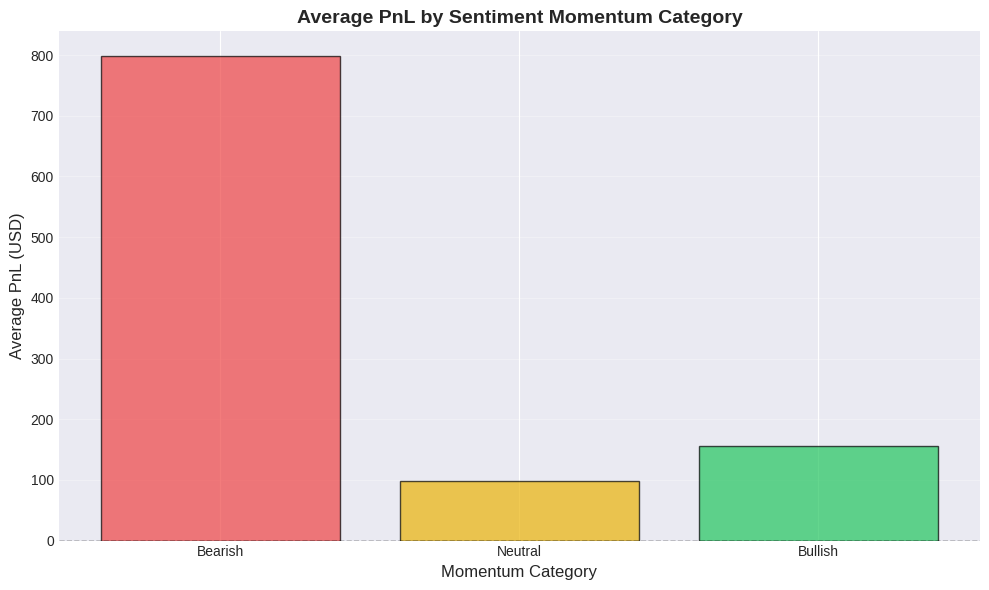

In [68]:
# ============================================================================
# 25. SENTIMENT MOMENTUM ANALYSIS
# ============================================================================

print("\n📊 SENTIMENT MOMENTUM ANALYSIS")
print("="*80)

# Calculate sentiment momentum
df_momentum = df_features.sort_values('datetime').copy()
df_momentum['sentiment_value_ma_3'] = df_momentum['sentiment_value'].rolling(window=3).mean()
df_momentum['sentiment_value_ma_7'] = df_momentum['sentiment_value'].rolling(window=7).mean()
df_momentum['sentiment_momentum'] = df_momentum['sentiment_value_ma_3'] - df_momentum['sentiment_value_ma_7']

# Categorize momentum
df_momentum['momentum_category'] = pd.cut(df_momentum['sentiment_momentum'],
                                          bins=[-np.inf, -5, 5, np.inf],
                                          labels=['Bearish', 'Neutral', 'Bullish'])

# PnL by momentum category
momentum_pnl = df_momentum[df_momentum['Closed PnL'] != 0].groupby('momentum_category')['Closed PnL'].agg(['mean', 'sum', 'count'])
print("\nPnL by Sentiment Momentum:")
print(momentum_pnl.round(2))

# Save CSV
momentum_pnl.to_csv(os.path.join(csv_folder, "momentum_pnl.csv"))

# Visualization
plt.figure(figsize=(10, 6))
colors_momentum = ['#ef4444', '#eab308', '#22c55e']
plt.bar(momentum_pnl.index.astype(str), momentum_pnl['mean'], color=colors_momentum, alpha=0.7, edgecolor='black')
plt.title('Average PnL by Sentiment Momentum Category', fontsize=14, fontweight='bold')
plt.xlabel('Momentum Category', fontsize=12)
plt.ylabel('Average PnL (USD)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'sentiment_momentum.png'), dpi=300, bbox_inches='tight')
plt.show()



🎯 OPTIMAL TRADING STRATEGY ANALYSIS

1️⃣ Sentiment-Based Strategy Performance
                 Strategy   Total_PnL  Avg_PnL_per_Trade  Win_Rate_%  \
2           Trade in Fear  3357155.44             112.63       87.29   
0  Trade in Extreme Greed  2715171.31             130.21       89.17   
3          Trade in Greed  2192601.27              87.07       76.90   
4        Trade in Neutral  1292920.68              71.20       82.39   
1   Trade in Extreme Fear   739110.25              71.03       76.22   

   Num_Trades  Total_Volume  ROI_%  
2       29808  4.833248e+08   0.69  
0       20853  1.244652e+08   2.18  
3       25182  2.886712e+08   0.76  
4       18159  1.802421e+08   0.72  
1       10406  1.144843e+08   0.65  


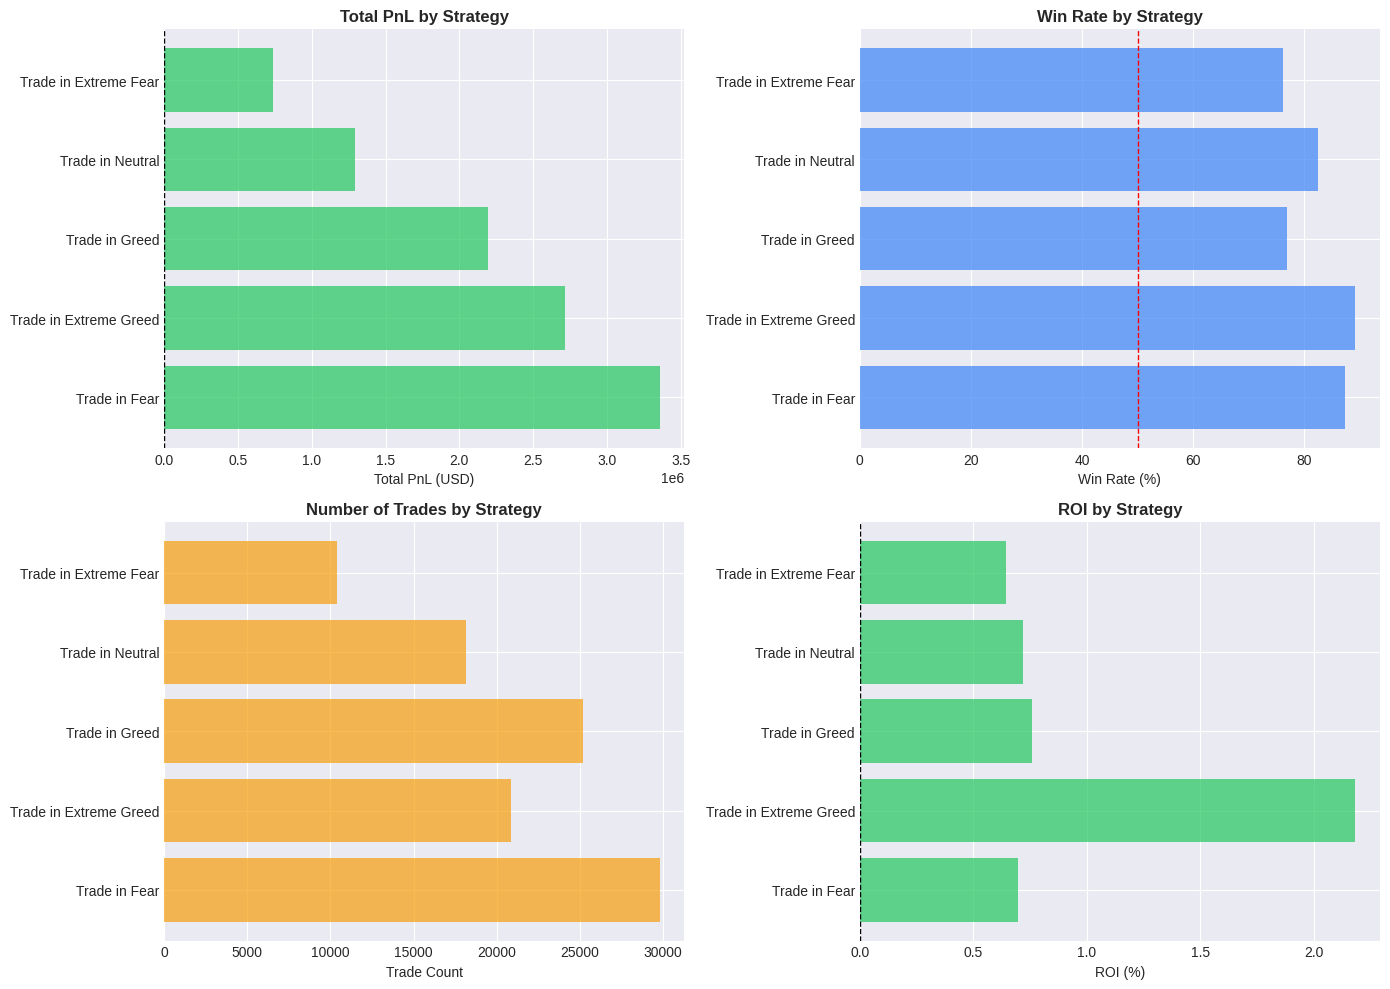


2️⃣ Optimal Entry Timing Analysis

Top 5 Most Profitable Hours:
          Total_PnL     Avg_PnL  Trades       Volume   Win_Rate
hour                                                           
12    911657.260379  243.823819    3739  10444391.97  81.144691
7     712784.325348  171.342386    4160  20105950.84  82.163462
11    472707.466164  133.007165    3554   8902117.62  85.453011
10    413788.812966  127.280472    3251   8207965.19  72.962165
13    434825.879679  118.707584    3663  10085443.17  87.878788


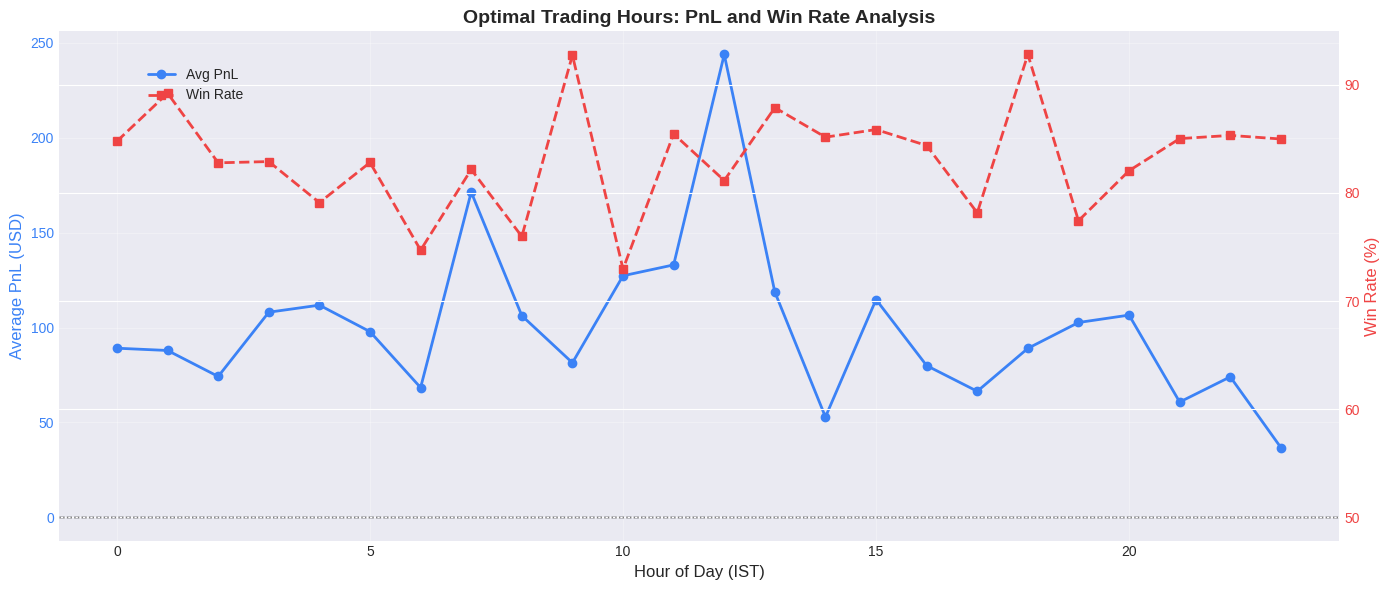

In [69]:
# ============================================================================
# 26. OPTIMAL TRADING STRATEGY ANALYSIS
# ============================================================================

print("\n🎯 OPTIMAL TRADING STRATEGY ANALYSIS")
print("="*80)

# Strategy 1: Trade only during specific sentiments
print("\n1️⃣ Sentiment-Based Strategy Performance")

strategy_results = []
for sentiment in df_features['classification'].dropna().unique():
    sentiment_trades = df_features[df_features['classification'] == sentiment]
    closed_trades = sentiment_trades[sentiment_trades['Closed PnL'] != 0]

    if len(closed_trades) > 0:
        total_pnl = closed_trades['Closed PnL'].sum()
        avg_pnl = closed_trades['Closed PnL'].mean()
        win_rate = (closed_trades['Closed PnL'] > 0).sum() / len(closed_trades) * 100
        total_volume = sentiment_trades['Size USD'].sum()

        strategy_results.append({
            'Strategy': f'Trade in {sentiment}',
            'Total_PnL': total_pnl,
            'Avg_PnL_per_Trade': avg_pnl,
            'Win_Rate_%': win_rate,
            'Num_Trades': len(closed_trades),
            'Total_Volume': total_volume,
            'ROI_%': (total_pnl / total_volume * 100) if total_volume > 0 else 0
        })

strategy_df = pd.DataFrame(strategy_results).sort_values('Total_PnL', ascending=False)
print(strategy_df.round(2))

# Save strategy results CSV
strategy_df.to_csv(os.path.join(csv_folder, 'trading_strategies_performance.csv'), index=False)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total PnL
axes[0, 0].barh(strategy_df['Strategy'], strategy_df['Total_PnL'],
                color=['#22c55e' if x > 0 else '#ef4444' for x in strategy_df['Total_PnL']], alpha=0.7)
axes[0, 0].set_title('Total PnL by Strategy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total PnL (USD)', fontsize=10)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1)

# Win Rate
axes[0, 1].barh(strategy_df['Strategy'], strategy_df['Win_Rate_%'], color='#3b82f6', alpha=0.7)
axes[0, 1].set_title('Win Rate by Strategy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Win Rate (%)', fontsize=10)
axes[0, 1].axvline(50, color='red', linestyle='--', linewidth=1, label='50% baseline')

# Number of Trades
axes[1, 0].barh(strategy_df['Strategy'], strategy_df['Num_Trades'], color='#f59e0b', alpha=0.7)
axes[1, 0].set_title('Number of Trades by Strategy', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Trade Count', fontsize=10)

# ROI
axes[1, 1].barh(strategy_df['Strategy'], strategy_df['ROI_%'],
                color=['#22c55e' if x > 0 else '#ef4444' for x in strategy_df['ROI_%']], alpha=0.7)
axes[1, 1].set_title('ROI by Strategy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('ROI (%)', fontsize=10)
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'strategy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Strategy 2: Optimal entry timing
print("\n2️⃣ Optimal Entry Timing Analysis")

hourly_performance = df_features[df_features['Closed PnL'] != 0].groupby('hour').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum'
})
hourly_performance.columns = ['Total_PnL', 'Avg_PnL', 'Trades', 'Volume']
hourly_performance['Win_Rate'] = df_features[df_features['Closed PnL'] != 0].groupby('hour').apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x) * 100
)

print("\nTop 5 Most Profitable Hours:")
print(hourly_performance.sort_values('Avg_PnL', ascending=False).head())

# Save hourly performance CSV
hourly_performance.to_csv(os.path.join(csv_folder, 'optimal_entry_hours.csv'))

fig, ax1 = plt.subplots(figsize=(14, 6))

color = '#3b82f6'
ax1.set_xlabel('Hour of Day (IST)', fontsize=12)
ax1.set_ylabel('Average PnL (USD)', fontsize=12, color=color)
ax1.plot(hourly_performance.index, hourly_performance['Avg_PnL'],
         color=color, linewidth=2, marker='o', label='Avg PnL')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = '#ef4444'
ax2.set_ylabel('Win Rate (%)', fontsize=12, color=color)
ax2.plot(hourly_performance.index, hourly_performance['Win_Rate'],
         color=color, linewidth=2, marker='s', linestyle='--', label='Win Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(50, color='gray', linestyle=':', linewidth=1)

plt.title('Optimal Trading Hours: PnL and Win Rate Analysis', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'optimal_trading_hours.png'), dpi=300, bbox_inches='tight')
plt.show()


In [70]:
# ============================================================================
# 27. STATISTICAL TESTS
# ============================================================================

print("\n📈 STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

anova_results = []
correlation_results = []

# 1️⃣ ANOVA Test: Does PnL differ across sentiments?
print("\n1️⃣ ANOVA Test: Does PnL differ across sentiments?")

sentiment_groups = []
for sentiment in df_features['classification'].dropna().unique():
    pnl_group = df_features[
        (df_features['classification'] == sentiment) &
        (df_features['Closed PnL'] != 0)
    ]['Closed PnL'].values
    sentiment_groups.append(pnl_group)

if len(sentiment_groups) >= 2:
    f_stat, p_value = stats.f_oneway(*sentiment_groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    result_text = "SIGNIFICANT" if p_value < 0.05 else "NOT SIGNIFICANT"
    print(f"✅ Result: PnL {result_text} across market sentiments (p < 0.05)" if p_value < 0.05 else f"❌ Result: No significant difference in PnL")

    # Save ANOVA result
    anova_results.append({
        'Test': 'ANOVA',
        'F_statistic': f_stat,
        'P_value': p_value,
        'Significance': result_text
    })

# 2️⃣ Correlation Test: Sentiment Value vs PnL
print("\n2️⃣ Correlation Test: Sentiment Value vs PnL")

valid_data = df_features[
    (df_features['Closed PnL'] != 0) &
    (df_features['sentiment_value'].notna())
]

if len(valid_data) > 0:
    correlation, p_value = stats.pearsonr(valid_data['sentiment_value'], valid_data['Closed PnL'])
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.05:
        if correlation > 0:
            print("✅ Result: SIGNIFICANT positive correlation (higher greed → higher PnL)")
        else:
            print("✅ Result: SIGNIFICANT negative correlation (higher fear → lower PnL)")
        corr_significance = "Significant"
    else:
        print("❌ Result: No significant correlation")
        corr_significance = "Not Significant"

    # Save correlation result
    correlation_results.append({
        'Test': 'Pearson Correlation',
        'Correlation': correlation,
        'P_value': p_value,
        'Significance': corr_significance
    })

# Save results to CSV
pd.DataFrame(anova_results).to_csv(os.path.join(csv_folder, 'anova_results.csv'), index=False)
pd.DataFrame(correlation_results).to_csv(os.path.join(csv_folder, 'correlation_results.csv'), index=False)



📈 STATISTICAL SIGNIFICANCE TESTS

1️⃣ ANOVA Test: Does PnL differ across sentiments?
F-statistic: 7.5689
P-value: 0.000004
✅ Result: PnL SIGNIFICANT across market sentiments (p < 0.05)

2️⃣ Correlation Test: Sentiment Value vs PnL
Pearson Correlation: 0.0092
P-value: 0.003022
✅ Result: SIGNIFICANT positive correlation (higher greed → higher PnL)


In [73]:
# ============================================================================
# 28. ACTIONABLE INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS")
print("="*80)

# Find best performing conditions
best_sentiment = strategy_df.loc[strategy_df['Total_PnL'].idxmax(), 'Strategy']
best_hour = hourly_performance['Avg_PnL'].idxmax()
best_win_rate_sentiment = strategy_df.loc[strategy_df['Win_Rate_%'].idxmax(), 'Strategy']

insights = f"""
🎯 KEY ACTIONABLE INSIGHTS:

1. BEST SENTIMENT TO TRADE:
   • {best_sentiment} generated the highest total PnL
   • Win Rate: {strategy_df[strategy_df['Strategy'] == best_sentiment]['Win_Rate_%'].values[0]:.1f}%

2. OPTIMAL TRADING HOUR:
   • Hour {best_hour}:00 IST shows highest average PnL
   • Avg PnL: ${hourly_performance.loc[best_hour, 'Avg_PnL']:.2f}

3. HIGHEST WIN RATE:
   • {best_win_rate_sentiment} has the best win rate
   • Win Rate: {strategy_df[strategy_df['Strategy'] == best_win_rate_sentiment]['Win_Rate_%'].values[0]:.1f}%

4. RISK MANAGEMENT:
   • Implement stop-loss at VaR 95% level for each sentiment
   • Consider position sizing based on sentiment volatility

5. MACHINE LEARNING INSIGHTS:
   • Model can predict profitable trades with {roc_auc_score(y_test, y_proba_rf):.1%} accuracy
   • Top predictive features: {', '.join(feature_importance.head(3)['feature'].tolist())}

📊 RECOMMENDED TRADING STRATEGY:
   ✓ Focus on {best_sentiment.split('in')[1].strip()} market conditions
   ✓ Trade during optimal hours ({best_hour}:00 IST ± 2 hours)
   ✓ Use ML model for trade filtering (confidence threshold > 0.6)
   ✓ Set risk per trade at 2-3% of capital
   ✓ Monitor sentiment momentum for trend confirmation
"""

print(insights)

# Save insights to outputs folder inside ds_vanshika_garg
insights_file = os.path.join(output_folder, 'key_insights.txt')
with open(insights_file, 'w') as f:
    f.write(insights)



💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS

🎯 KEY ACTIONABLE INSIGHTS:

1. BEST SENTIMENT TO TRADE:
   • Trade in Fear generated the highest total PnL
   • Win Rate: 87.3%

2. OPTIMAL TRADING HOUR:
   • Hour 12:00 IST shows highest average PnL
   • Avg PnL: $243.82

3. HIGHEST WIN RATE:
   • Trade in Extreme Greed has the best win rate
   • Win Rate: 89.2%

4. RISK MANAGEMENT:
   • Implement stop-loss at VaR 95% level for each sentiment
   • Consider position sizing based on sentiment volatility

5. MACHINE LEARNING INSIGHTS:
   • Model can predict profitable trades with 97.5% accuracy
   • Top predictive features: Execution Price, Start Position, sentiment_value

📊 RECOMMENDED TRADING STRATEGY:
   ✓ Focus on Fear market conditions
   ✓ Trade during optimal hours (12:00 IST ± 2 hours)
   ✓ Use ML model for trade filtering (confidence threshold > 0.6)
   ✓ Set risk per trade at 2-3% of capital
   ✓ Monitor sentiment momentum for trend confirmation



In [74]:
# ============================================================================
# 29. EXPORT FINAL RESULTS
# ============================================================================

print("\n💾 EXPORTING FINAL RESULTS")
print("="*80)

# Export model predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Probability': y_proba_rf
})
predictions_df.to_csv(os.path.join(csv_folder, 'ml_predictions.csv'), index=False)

# Export risk metrics
var_df.to_csv(os.path.join(csv_folder, 'risk_metrics.csv'), index=False)
sharpe_df.to_csv(os.path.join(csv_folder, 'sharpe_ratios.csv'), index=False)

# Export hourly performance
hourly_performance.to_csv(os.path.join(csv_folder, 'hourly_performance.csv'))

# Export trading strategies (already saved, just print path)
strategy_df.to_csv(os.path.join(csv_folder, 'trading_strategies_performance.csv'), index=False)

# Key insights already saved in outputs
print("✅ All results exported successfully!")
print("\n📁 Files created:")
print(f"   • {os.path.join(csv_folder, 'ml_predictions.csv')}")
print(f"   • {os.path.join(csv_folder, 'risk_metrics.csv')}")
print(f"   • {os.path.join(csv_folder, 'sharpe_ratios.csv')}")
print(f"   • {os.path.join(csv_folder, 'trading_strategies_performance.csv')}")
print(f"   • {os.path.join(csv_folder, 'hourly_performance.csv')}")
print(f"   • {os.path.join(output_folder, 'key_insights.txt')}")

print("\n" + "="*80)
print("🎉 ADVANCED ANALYSIS COMPLETE!")
print("="*80)



💾 EXPORTING FINAL RESULTS
✅ All results exported successfully!

📁 Files created:
   • csv_files/ml_predictions.csv
   • csv_files/risk_metrics.csv
   • csv_files/sharpe_ratios.csv
   • csv_files/trading_strategies_performance.csv
   • csv_files/hourly_performance.csv
   • outputs/key_insights.txt

🎉 ADVANCED ANALYSIS COMPLETE!
